In [ ]:
import os

In [ ]:
# hyperparameters

# limit senetences to 128 token
MAX_LEN = 128
# for training taaghche
# TRAIN_BATCH_SIZE = 16
# for training stocks
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 4
LEARNING_RATE = 2e-5
# to prevent exploding gradient problem
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = './model'
OUTPUT_MODEL_PATH = f'{OUTPUT_PATH}/model-final.bin'

os.makedirs(OUTPUT_PATH, exist_ok=True)

trainMode = True
# trainDataset = 'taaghche'

trainDataset = 'stocks'
# trainDatasetFile = 'sentiment'
trainDatasetFile = 'signal'


# do validation every ? steps (each mini batch)
if trainDataset == 'taaghche':
    EEVERY_EPOCH = 1000
else:
    EEVERY_EPOCH = 14

In [ ]:
!mkdir dataset
!wget https://ahmadian.me/final-dataset/taaghche.csv -O dataset/taaghche.csv

!wget https://ahmadian.me/final-dataset/stocks-test-sentiment.csv -O dataset/stocks-test-sentiment.csv
!wget https://ahmadian.me/final-dataset/stocks-test-signal.csv -O dataset/stocks-test-signal.csv
!wget https://ahmadian.me/final-dataset/stocks-train-sentiment.csv -O dataset/stocks-train-sentiment.csv
!wget https://ahmadian.me/final-dataset/stocks-train-signal.csv -O dataset/stocks-train-signal.csv

--2022-06-30 00:02:27--  https://ahmadian.me/final-dataset/taaghche.csv
Resolving ahmadian.me (ahmadian.me)... 157.90.0.201
Connecting to ahmadian.me (ahmadian.me)|157.90.0.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22056405 (21M) [text/csv]
Saving to: ‘dataset/taaghche.csv’

dataset/taaghche.cs 100%[===================>]  21.03M  11.2MB/s    in 1.9s    

2022-06-30 00:02:30 (11.2 MB/s) - ‘dataset/taaghche.csv’ saved [22056405/22056405]

--2022-06-30 00:02:30--  https://ahmadian.me/final-dataset/stocks-test-sentiment.csv
Resolving ahmadian.me (ahmadian.me)... 157.90.0.201
Connecting to ahmadian.me (ahmadian.me)|157.90.0.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287771 (281K) [text/csv]
Saving to: ‘dataset/stocks-test-sentiment.csv’

dataset/stocks-test 100%[===================>] 281.03K   488KB/s    in 0.6s    

2022-06-30 00:02:31 (488 KB/s) - ‘dataset/stocks-test-sentiment.csv’ saved [287771/287771]

--2022-06-30 

In [ ]:
# !mkdir model
!wget https://ahmadian.me/final-dataset/bert-taaghche/model-e1.bin -O model/model-e1.bin
!wget https://ahmadian.me/final-dataset/bert-taaghche/model-e2.bin -O model/model-e2.bin
!wget https://ahmadian.me/final-dataset/bert-taaghche/model-e3.bin -O model/model-e3.bin
!wget https://ahmadian.me/final-dataset/bert-taaghche/model-e4.bin -O model/model-e4.bin

In [ ]:
!pip install -q transformers==3.1.0
# word-level tokenizer
!pip install -qU hazm
# clean messages
!pip install -qU clean-text[gpl]

     |████████████████████████████████| 884 kB 7.3 MB/s 
     |████████████████████████████████| 1.2 MB 42.1 MB/s 
     |████████████████████████████████| 3.0 MB 42.3 MB/s 
     |████████████████████████████████| 880 kB 56.5 MB/s 
     |████████████████████████████████| 316 kB 7.8 MB/s 
     |████████████████████████████████| 233 kB 51.7 MB/s 
     |████████████████████████████████| 1.4 MB 52.2 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 175 kB 16.6 MB/s 
     |████████████████████████████████| 235 kB 55.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import re
import json
import copy
import collections
import matplotlib.pyplot as plt

In [ ]:
#read csv files and initial preprocessing
if trainDataset == 'taaghche':

    data = pd.read_csv('dataset/taaghche.csv', encoding='utf-8')
    data = data[['comment', 'rate']]


    # handle some conflicts with the dataset structure
    # you can find a reliable solution, for the sake of the simplicity
    # I just remove these bad combinations!
    data['rate'] = data['rate'].apply(lambda r: r if r < 6 else None)

    data = data.dropna(subset=['rate'])
    data = data.dropna(subset=['comment'])
    data = data.drop_duplicates(subset=['comment'], keep='first')
    data = data.reset_index(drop=True)


    # calculate the length of comments based on their words
    data['comment_len_by_words'] = data['comment'].apply(lambda t: len(hazm.word_tokenize(t)))


    def rate_to_label(rate, threshold=3.0):
        if rate <= threshold:
            return 'negative'
        else:
            return 'positive'


    data['label'] = data['rate'].apply(lambda t: rate_to_label(t, 3.0))
    data.head()

elif trainDataset == 'stocks':

    if trainDatasetFile == 'sentiment':
        data = pd.read_csv('dataset/stocks-train-sentiment.csv', encoding='utf-8')
        data = data[['message', 'sentiment_label']]
        data = data.rename(columns={"message": "comment", "sentiment_label": "label_id"})
    else:
        data = pd.read_csv('dataset/stocks-train-signal.csv', encoding='utf-8')
        data = data[['message', 'signal_label']]
        data = data.rename(columns={"message": "comment", "signal_label": "label_id"})


    

    # remove neutral label_id in sentiment analisys to match with taaghche dataset
    data = data[data['label_id'] != 0]

    data['label'] = data['label_id']
    data = data.replace({'label': {0: 'neutral', 1: 'positive', 2: 'negative'}})


    # calculate the length of comments based on their words
    data['comment_len_by_words'] = data['comment'].apply(lambda t: len(hazm.word_tokenize(t)))




    if trainDatasetFile == 'sentiment':
        dataTest = pd.read_csv('dataset/stocks-test-sentiment.csv', encoding='utf-8')
        dataTest = dataTest[['message', 'sentiment_label']]
        dataTest = dataTest.rename(columns={"message": "comment", "sentiment_label": "label_id"})
    else:
        dataTest = pd.read_csv('dataset/stocks-test-signal.csv', encoding='utf-8')
        dataTest = dataTest[['message', 'signal_label']]
        dataTest = dataTest.rename(columns={"message": "comment", "signal_label": "label_id"})


    dataTest = dataTest[dataTest['label_id'] != 0]

    dataTest['label'] = dataTest['label_id']
    dataTest = dataTest.replace({'label': {0: 'neutral', 1: 'positive', 2: 'negative'}})


    # calculate the length of comments based on their words
    dataTest['comment_len_by_words'] = dataTest['comment'].apply(lambda t: len(hazm.word_tokenize(t)))




labels = list(sorted(data['label'].unique()))

In [ ]:
# keep comments between less_than and greater_than words
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='comment_len_by_words'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [ ]:
# message cleaning functions
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()

    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# apply cleaning functions
data_gl_than(data, 256, 3)


minlim, maxlim = 3, 256


# remove comments with the length of fewer than three words
data['comment_len_by_words'] = data['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
data = data.dropna(subset=['comment_len_by_words'])
data = data.reset_index(drop=True)


# cleaning comments
data['cleaned_comment'] = data['comment'].apply(cleaning)


# calculate the length of comments based on their words
data['cleaned_comment_len_by_words'] = data['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

# remove comments with the length of fewer than three words
data['cleaned_comment_len_by_words'] = data['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
data = data.dropna(subset=['cleaned_comment_len_by_words'])
data = data.reset_index(drop=True)

data.head()


data = data[['cleaned_comment', 'label']]
data.columns = ['comment', 'label']
data.head()


if trainDataset == 'stocks':
    data_gl_than(dataTest, 256, 3)


    minlim, maxlim = 3, 256


    # remove comments with the length of fewer than three words
    dataTest['comment_len_by_words'] = dataTest['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
    dataTest = dataTest.dropna(subset=['comment_len_by_words'])
    dataTest = dataTest.reset_index(drop=True)


    # cleaning comments
    dataTest['cleaned_comment'] = dataTest['comment'].apply(cleaning)


    # calculate the length of comments based on their words
    dataTest['cleaned_comment_len_by_words'] = dataTest['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))

    # remove comments with the length of fewer than three words
    dataTest['cleaned_comment_len_by_words'] = dataTest['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
    dataTest = dataTest.dropna(subset=['cleaned_comment_len_by_words'])
    dataTest = dataTest.reset_index(drop=True)

    dataTest.head()


    dataTest = dataTest[['cleaned_comment', 'label']]
    dataTest.columns = ['comment', 'label']
    dataTest.head()

Texts with word length of greater than 3 and less than 256 includes 98.21% of the whole!
Texts with word length of greater than 3 and less than 256 includes 100.00% of the whole!


Again, for making things simple. We cut the dataset randomly based on the fewer label, the negative class.

In [ ]:
new_data = data

if trainDataset == 'stocks':
    new_data_test = dataTest

In [ ]:
# split data to train validation test sets
new_data['label_id'] = new_data['label'].apply(lambda t: labels.index(t))

if trainDataset == 'stocks':
    new_data_test['label_id'] = new_data_test['label'].apply(lambda t: labels.index(t))
    valid, test = train_test_split(new_data_test, test_size=0.1, random_state=1, stratify=new_data_test['label'])
    train = data
else:
    train, test = train_test_split(new_data, test_size=0.1, random_state=1, stratify=new_data['label'])
    train, valid = train_test_split(train, test_size=0.1, random_state=1, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

x_train, y_train = train['comment'].values.tolist(), train['label_id'].values.tolist()
x_valid, y_valid = valid['comment'].values.tolist(), valid['label_id'].values.tolist()
x_test, y_test = test['comment'].values.tolist(), test['label_id'].values.tolist()

print(train.shape)
print(valid.shape)
print(test.shape)

(110, 3)
(34, 3)
(4, 3)


## PyTorch

In [ ]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F

### Configuration

In [ ]:
# check if server has gpu or not
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda:0


In [ ]:
# create a key finder based on label 2 id and id to label

label2id = {label: i for i, label in enumerate(labels)}
id2label = {v: k for k, v in label2id.items()}

print(f'label2id: {label2id}')
print(f'id2label: {id2label}')

label2id: {'negative': 0, 'positive': 1}
id2label: {0: 'negative', 1: 'positive'}


In [ ]:
# setup the tokenizer and configuration

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

Downloading:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440 [00:00<?, ?B/s]

{
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 100000
}



### Dataset

In [ ]:
# feed data to pytorch dataloder class
class TaaghcheDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, comments, targets=None, label_list=None, max_len=128):
        self.comments = comments
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
    
    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        if self.has_target:
            target = self.label_map.get(str(self.targets[item]), str(self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['targets'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = TaaghcheDataset(
        comments=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
# create dataloader instances
label_list = ['negative', 'positive']
train_data_loader = create_data_loader(train['comment'].to_numpy(), train['label'].to_numpy(), tokenizer, MAX_LEN, TRAIN_BATCH_SIZE, label_list)
valid_data_loader = create_data_loader(valid['comment'].to_numpy(), valid['label'].to_numpy(), tokenizer, MAX_LEN, VALID_BATCH_SIZE, label_list)
test_data_loader = create_data_loader(test['comment'].to_numpy(), None, tokenizer, MAX_LEN, TEST_BATCH_SIZE, label_list)

In [ ]:
#define the sentiment model
class SentimentModel(nn.Module):

    def __init__(self, config):
        super(SentimentModel, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, pooled_output = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits 

In [ ]:
# create sentiment model instance
pt_model = SentimentModel(config=config)
pt_model = pt_model.to(device)

print('pt_model', type(pt_model))

Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

pt_model <class '__main__.SentimentModel'>


### Training

In [ ]:
# define metric functions
def simple_accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()

def acc_and_f1(y_true, y_pred, average='weighted'):
    acc = simple_accuracy(y_true, y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average=average)
    return {
        "acc": acc,
        "f1": f1,
    }

def y_loss(y_true, y_pred, losses):
    y_true = torch.stack(y_true).cpu().detach().numpy()
    y_pred = torch.stack(y_pred).cpu().detach().numpy()
    y = [y_true, y_pred]
    loss = np.mean(losses)

    return y, loss








# definne validation function for 1 epoch
def eval_op(model, data_loader, loss_fn):
    model.eval()

    losses = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for dl in tqdm(data_loader, total=len(data_loader), desc="Evaluation... "):
            
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']
            targets = dl['targets']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            targets = targets.to(device)

            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            # calculate the batch loss
            loss = loss_fn(outputs, targets)

            # accumulate all the losses
            losses.append(loss.item())

            y_pred.extend(preds)
            y_true.extend(targets)
    
    eval_y, eval_loss = y_loss(y_true, y_pred, losses)
    return eval_y, eval_loss








#define train function for 1 epoch
def train_op(model, 
             data_loader, 
             loss_fn, 
             optimizer, 
             scheduler, 
             step=0, 
             print_every_step=100, 
             eval=False,
             eval_cb=None,
             eval_loss_min=np.Inf,
             eval_data_loader=None, 
             clip=0.0,
             epoch=0):
    
    model.train()

    losses = []
    y_pred = []
    y_true = []

    for dl in tqdm(data_loader, total=len(data_loader), desc="Training... "):
        step += 1

        input_ids = dl['input_ids']
        attention_mask = dl['attention_mask']
        token_type_ids = dl['token_type_ids']
        targets = dl['targets']

        # move tensors to GPU if CUDA is available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        targets = targets.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # compute predicted outputs by passing inputs to the model
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)
        
        # convert output probabilities to predicted class
        _, preds = torch.max(outputs, dim=1)

        # calculate the batch loss
        loss = loss_fn(outputs, targets)

        # accumulate all the losses
        losses.append(loss.item())

        # compute gradient of the loss with respect to model parameters
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        if clip > 0.0:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)

        # perform optimization step
        optimizer.step()

        # perform scheduler step
        scheduler.step()

        y_pred.extend(preds)
        y_true.extend(targets)

        if eval:
            train_y, train_loss = y_loss(y_true, y_pred, losses)
            train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')

            if step % print_every_step == 0:
                eval_y, eval_loss = eval_op(model, eval_data_loader, loss_fn)
                eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')

                if hasattr(eval_cb, '__call__'):
                    eval_loss_min = eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min)

    train_y, train_loss = y_loss(y_true, y_pred, losses)

    torch.save(model.state_dict(), 'model/model-e' + str(epoch) + '.bin')

    return train_y, train_loss, step, eval_loss_min

In [ ]:
optimizer = AdamW(pt_model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

step = 0
eval_loss_min = np.Inf
history = collections.defaultdict(list)


def eval_callback(epoch, epochs, output_path):
    def eval_cb(model, step, train_score, train_loss, eval_score, eval_loss, eval_loss_min):
        statement = ''
        statement += 'Epoch: {}/{}...'.format(epoch, epochs)
        statement += 'Step: {}...'.format(step)
        
        statement += 'Train Loss: {:.6f}...'.format(train_loss)
        statement += 'Train Acc: {:.3f}...'.format(train_score['acc'])

        statement += 'Valid Loss: {:.6f}...'.format(eval_loss)
        statement += 'Valid Acc: {:.3f}...'.format(eval_score['acc'])

        print(statement)

        if eval_loss <= eval_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                eval_loss_min,
                eval_loss))
            
            torch.save(model.state_dict(), output_path)
            eval_loss_min = eval_loss
        
        return eval_loss_min


    return eval_cb







# main train loops on epochs
if trainMode:
    for epoch in tqdm(range(1, EPOCHS + 1), desc="Epochs... "):
        train_y, train_loss, step, eval_loss_min = train_op(
            model=pt_model, 
            data_loader=train_data_loader, 
            loss_fn=loss_fn, 
            optimizer=optimizer, 
            scheduler=scheduler, 
            step=step, 
            print_every_step=EEVERY_EPOCH, 
            eval=True,
            eval_cb=eval_callback(epoch, EPOCHS, OUTPUT_MODEL_PATH),
            eval_loss_min=eval_loss_min,
            eval_data_loader=valid_data_loader, 
            clip=CLIP,
            epoch=epoch)
        
        train_score = acc_and_f1(train_y[0], train_y[1], average='weighted')
        
        eval_y, eval_loss = eval_op(
            model=pt_model, 
            data_loader=valid_data_loader, 
            loss_fn=loss_fn)
        
        eval_score = acc_and_f1(eval_y[0], eval_y[1], average='weighted')
        
        history['train_acc'].append(train_score['acc'])
        history['train_loss'].append(train_loss)
        history['val_acc'].append(eval_score['acc'])
        history['val_loss'].append(eval_loss)

Epochs... :   0%|          | 0/4 [00:00<?, ?it/s]

Training... :   0%|          | 0/14 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1/4...Step: 14...Train Loss: 0.603839...Train Acc: 0.864...Valid Loss: 1.248253...Valid Acc: 0.147...
Validation loss decreased (inf --> 1.248253).  Saving model ...


Evaluation... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/14 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2/4...Step: 28...Train Loss: 0.787449...Train Acc: 0.573...Valid Loss: 0.803839...Valid Acc: 0.147...
Validation loss decreased (1.248253 --> 0.803839).  Saving model ...


Evaluation... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/14 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3/4...Step: 42...Train Loss: 0.738333...Train Acc: 0.709...Valid Loss: 1.081619...Valid Acc: 0.853...


Evaluation... :   0%|          | 0/3 [00:00<?, ?it/s]

Training... :   0%|          | 0/14 [00:00<?, ?it/s]

Evaluation... :   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4/4...Step: 56...Train Loss: 0.483497...Train Acc: 0.845...Valid Loss: 1.036128...Valid Acc: 0.853...


Evaluation... :   0%|          | 0/3 [00:00<?, ?it/s]

### Prediction/Evaluation

In [ ]:
# define test function (prediction function)
def predict(model, comments, tokenizer, max_len=128, batch_size=32):
    data_loader = create_data_loader(comments, None, tokenizer, max_len, batch_size, None)
    
    predictions = []
    prediction_probs = []

    
    # model.eval()
    with torch.no_grad():
        for dl in tqdm(data_loader, position=0):
            input_ids = dl['input_ids']
            attention_mask = dl['attention_mask']
            token_type_ids = dl['token_type_ids']

            # move tensors to GPU if CUDA is available
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            
            # compute predicted outputs by passing inputs to the model
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            # convert output probabilities to predicted class
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            prediction_probs.extend(F.softmax(outputs, dim=1))

    predictions = torch.stack(predictions).cpu().detach().numpy()
    prediction_probs = torch.stack(prediction_probs).cpu().detach().numpy()

    return predictions, prediction_probs

In [ ]:
def plotTestResults(results):
    presicions = [results[0]['weighted avg']['precision']]
    recalls = [results[0]['weighted avg']['recall']]
    f1s = [results[0]['weighted avg']['f1-score']]

    print(results)

    for result in results:
        presicions.append(result['weighted avg']['precision'])
        recalls.append(result['weighted avg']['recall'])
        f1s.append(result['weighted avg']['f1-score'])


    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Test Results per Epoch')
    plt.plot(presicions, color='green', marker='.', label='Precision')
    plt.plot(recalls, color='blue', marker='.', label='Recall')
    plt.plot(f1s, color='red', marker='.', label='F1 Score')
    plt.legend()
    plt.show()

Testing Epoch 1:


  0%|          | 0/1 [00:00<?, ?it/s]

F1: 0.1

{'negative': {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 1}, 'positive': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'accuracy': 0.25, 'macro avg': {'precision': 0.125, 'recall': 0.5, 'f1-score': 0.2, 'support': 4}, 'weighted avg': {'precision': 0.0625, 'recall': 0.25, 'f1-score': 0.1, 'support': 4}}


Testing Epoch 2:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/1 [00:00<?, ?it/s]

F1: 0.1

{'negative': {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 1}, 'positive': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'accuracy': 0.25, 'macro avg': {'precision': 0.125, 'recall': 0.5, 'f1-score': 0.2, 'support': 4}, 'weighted avg': {'precision': 0.0625, 'recall': 0.25, 'f1-score': 0.1, 'support': 4}}


Testing Epoch 3:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/1 [00:00<?, ?it/s]

F1: 0.6428571428571428

{'negative': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'positive': {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 3}, 'accuracy': 0.75, 'macro avg': {'precision': 0.375, 'recall': 0.5, 'f1-score': 0.42857142857142855, 'support': 4}, 'weighted avg': {'precision': 0.5625, 'recall': 0.75, 'f1-score': 0.6428571428571428, 'support': 4}}


Testing Epoch 4:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/1 [00:00<?, ?it/s]

F1: 0.6428571428571428

{'negative': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'positive': {'precision': 0.75, 'recall': 1.0, 'f1-score': 0.8571428571428571, 'support': 3}, 'accuracy': 0.75, 'macro avg': {'precision': 0.375, 'recall': 0.5, 'f1-score': 0.42857142857142855, 'support': 4}, 'weighted avg': {'precision': 0.5625, 'recall': 0.75, 'f1-score': 0.6428571428571428, 'support': 4}}


[{'negative': {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 1}, 'positive': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'accuracy': 0.25, 'macro avg': {'precision': 0.125, 'recall': 0.5, 'f1-score': 0.2, 'support': 4}, 'weighted avg': {'precision': 0.0625, 'recall': 0.25, 'f1-score': 0.1, 'support': 4}}, {'negative': {'precision': 0.25, 'recall': 1.0, 'f1-score': 0.4, 'support': 1}, 'positive': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, 'accuracy': 0.25, 'macro avg': {'precision': 0.125, 'recall': 0.5, 'f1-score': 0.2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


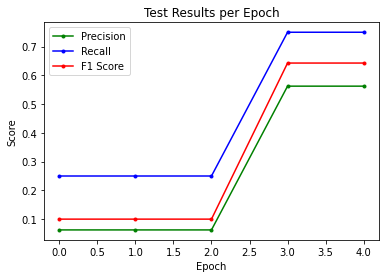

In [ ]:
# test tr
results = []

for epoch in range(EPOCHS):
    print('Testing Epoch ' + str(epoch+1) + ':')

    model = SentimentModel(config=config)
    model.load_state_dict(torch.load('model/model-e' + str(epoch+1) + '.bin', map_location=device))
    model.to(device)

    test_comments = test['comment'].to_numpy()
    preds, probs = predict(model, test_comments, tokenizer, max_len=128)

    y_test, y_pred = [label_list.index(label) for label in test['label'].values], preds

    print(f'F1: {f1_score(y_test, y_pred, average="weighted")}')
    print()
    report = classification_report(y_test, y_pred, target_names=label_list, output_dict=True)
    results.append(report)
    print(report)
    print()
    print()

plotTestResults(results)

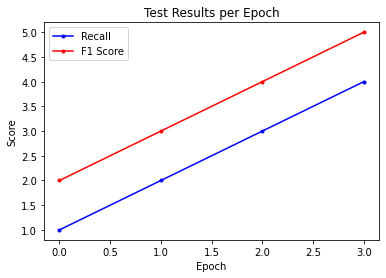

In [ ]:
import matplotlib.pyplot as plt

train_loss = [1,2,3,4]
validation_loss = [2,3,4,5]

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Test Results per Epoch')
plt.plot(train_loss, color='blue', marker='.', label='Recall')
plt.plot(validation_loss, color='red', marker='.', label='F1 Score')
plt.legend()
plt.show()